In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

In [3]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [4]:
df.shape[0]

2913955

In [9]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


### Q1 - how many columns

In [10]:
print(len(df.columns))

19


### Q2 - computing duration

In [19]:
# calculate trip duration and convert to minutes
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [20]:
duration_std = df['duration'].std()
duration_std

42.594351241920904

### Q3 - dropping outliers

In [21]:
mask = df['duration'].between(1, 60)
valid_count = mask.sum()
outlier_count = len(df) - valid_count
outlier_pct = 100 * valid_count / len(df)

print(f"total rows: {len(df)}")
print(f"outliers: {outlier_count}")
print(f"outlier fraction: {outlier_pct:.2f}%")

total rows: 3066766
outliers: 57593
outlier fraction: 98.12%


In [14]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

### Q4 - one hot encoding

In [15]:
# create features
categorical = ['PULocationID', 'DOLocationID']
df[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [16]:
# convert to strings
df[categorical] = df[categorical].astype(str)

In [17]:
df[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [18]:
train_dicts = df[categorical].to_dict(orient='records')

In [19]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [21]:
X_train.shape

(3009173, 515)

In [20]:
len(dv.feature_names_)

515

### Q5 - training model

In [22]:
target = 'duration'
y_train = df[target].values

In [23]:
y_train

array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
       13.        , 14.4       ])

In [24]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [25]:
y_pred = lr.predict(X_train)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 75.0)

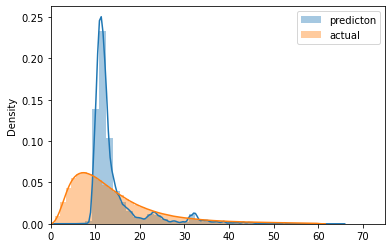

In [27]:
sns.distplot(y_pred, label='predicton')
sns.distplot(y_train, label='actual')

plt.legend()
plt.xlim(0, 75) 

In [29]:
mean_squared_error(y_train, y_pred, squared=False)

7.649261027792376

### Q6 - evaluating model

In [10]:
def read_dataframe(filename):
  df = pd.read_parquet(filename)

  # convert values to datetime
  df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
  df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)

  # calculate trip duration and convert to minutes
  df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
  df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

  # filter trips between 1 and 60 mins
  df = df[(df.duration >= 1) & (df.duration <= 60)]

  # convert categorical features to strings
  categorical = ['PULocationID', 'DOLocationID']
  df[categorical] = df[categorical].astype(str)

  return df

In [11]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [ ]:
categorical = ['PULocationID', 'DOLocationID']

dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)


In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.8118325109416915